In [1]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import root_mean_squared_error

In [2]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='/workspaces/mlops-zoomcamp-25/02-experiment-tracking/mlruns/1', creation_time=1746490334307, experiment_id='1', last_update_time=1746490334307, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [3]:
df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [4]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

root_mean_squared_error(y_train, y_pred)

9.838799799829577

/tmp/ipykernel_2780/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_2780/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


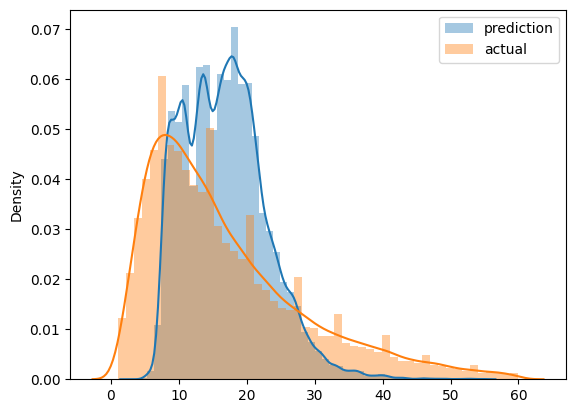

In [5]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [6]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [7]:
df_train = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet')

In [8]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [9]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [10]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [11]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

7.758715209663881

In [12]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [17]:
with mlflow.start_run():

    mlflow.set_tag("developer","stefan")
    mlflow.log_param("train-data-path", "internet")
    mlflow.log_param("valid-data-path", "web3")

    alpha = 0.1
    mlflow.log_param("alpha",alpha)

    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = root_mean_squared_error(y_val, y_pred)

    mlflow.log_metric("rmse",rmse)

    mlflow.log_artifact(local_path='models/lin_reg.bin',artifact_path='models_pickle')

In [18]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [19]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [20]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = root_mean_squared_error(y_val, y_pred)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [17]:
"""
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=5,
    trials=Trials()
)
"""

"\nsearch_space = {\n    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),\n    'learning_rate': hp.loguniform('learning_rate', -3, 0),\n    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),\n    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),\n    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),\n    'objective': 'reg:linear',\n    'seed': 42\n}\n\nbest_result = fmin(\n    fn=objective,\n    space=search_space,\n    algo=tpe.suggest,\n    max_evals=5,\n    trials=Trials()\n)\n"

In [18]:
params = {
    "learning_rate": 0.12108176669899365,
    "max_depth": 39,
    "min_child_weight": 17.41633218421994,
    "objective": "reg:linear",
    "reg_alpha": 0.2964895764427428,
    "reg_lambda": 0.003564977750019755,
    "seed": 42
}

# mlflow.xgboost.autolog()

booster = xgb.train(
    params=params,
    dtrain=train,
    num_boost_round=1000,
    evals=[(valid, 'validation')],
    early_stopping_rounds=50
)

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [00:51:40] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:11.26367
[1]	validation-rmse:10.46413
[2]	validation-rmse:9.79553
[3]	validation-rmse:9.23888
[4]	validation-rmse:8.77883
[5]	validation-rmse:8.40027
[6]	validation-rmse:8.09046
[7]	validation-rmse:7.83812
[8]	validation-rmse:7.63158
[9]	validation-rmse:7.46379
[10]	validation-rmse:7.32808
[11]	validation-rmse:7.21816
[12]	validation-rmse:7.12928
[13]	validation-rmse:7.05709
[14]	validation-rmse:6.99833
[15]	validation-rmse:6.95041
[16]	validation-rmse:6.90894
[17]	validation-rmse:6.87467
[18]	validation-rmse:6.84634
[19]	validation-rmse:6.82253
[20]	validation-rmse:6.80329
[21]	validation-rmse:6.78586
[22]	validation-rmse:6.77176
[23]	validation-rmse:6.75938
[24]	validation-rmse:6.74934
[25]	validation-rmse:6.74086
[26]	validation-rmse:6.73340
[27]	validation-rmse:6.72709
[28]	validation-rmse:6.72123
[29]	validation-rmse:6.71445
[30]	validation-rmse:6.71001
[31]	validation-rmse:6.70596
[32]	validation-rmse:6.70130
[33]	validation-rmse:6.69712
[34]	validation-rmse:6

In [22]:
with mlflow.start_run():

    train = xgb.DMatrix(X_train, label=y_train)
    valid = xgb.DMatrix(X_val, label=y_val)

    params = {
        "learning_rate": 0.12108176669899365,
        "max_depth": 39,
        "min_child_weight": 17.41633218421994,
        "objective": "reg:linear",
        "reg_alpha": 0.2964895764427428,
        "reg_lambda": 0.003564977750019755,
        "seed": 42
    }

    mlflow.log_params(params)

    booster = xgb.train(
        params=params,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid, 'validation')],
        early_stopping_rounds=50
    )

    y_pred = booster.predict(valid)
    rmse = root_mean_squared_error(y_val,y_pred)
    mlflow.log_metric("rmse",rmse)

    with open("models/preprocessor.b","wb") as f:
        pickle.dump(dv,f)

    mlflow.log_artifact("models/preprocessor.b",artifact_path="preprocessor")

    mlflow.xgboost.log_model(booster,artifact_path = 'models_mlflow')

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:48:53] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:11.26367
[1]	validation-rmse:10.46413
[2]	validation-rmse:9.79553
[3]	validation-rmse:9.23888
[4]	validation-rmse:8.77883
[5]	validation-rmse:8.40027
[6]	validation-rmse:8.09046
[7]	validation-rmse:7.83812
[8]	validation-rmse:7.63158
[9]	validation-rmse:7.46379
[10]	validation-rmse:7.32808
[11]	validation-rmse:7.21816
[12]	validation-rmse:7.12928
[13]	validation-rmse:7.05709
[14]	validation-rmse:6.99833
[15]	validation-rmse:6.95041
[16]	validation-rmse:6.90894
[17]	validation-rmse:6.87467
[18]	validation-rmse:6.84634
[19]	validation-rmse:6.82253
[20]	validation-rmse:6.80329
[21]	validation-rmse:6.78586
[22]	validation-rmse:6.77176
[23]	validation-rmse:6.75938
[24]	validation-rmse:6.74934
[25]	validation-rmse:6.74086
[26]	validation-rmse:6.73340
[27]	validation-rmse:6.72709
[28]	validation-rmse:6.72123
[29]	validation-rmse:6.71445
[30]	validation-rmse:6.71001
[31]	validation-rmse:6.70596
[32]	validation-rmse:6.70130
[33]	validation-rmse:6.69712
[34]	validation-rmse:6

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:51:33] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2025/05/06 03:51:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [24]:
logged_model = 'runs:/d201213f07224203a9978aabaa54acb3/models_mlflow'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

In [25]:
xgboost_model = mlflow.xgboost.load_model(logged_model)

In [26]:
y_pred = xgboost_model.predict(valid)

In [27]:
y_pred[:10]

array([14.569569 ,  6.5793037, 21.455252 , 24.726576 ,  9.170569 ,
       17.165718 , 14.530701 ,  9.075235 ,  9.188553 , 18.460672 ],
      dtype=float32)